In [1]:
from collections.abc import Callable
import numpy as np
import market_plotting_utils as mpu
import market_simulation_utils as msu
import matplotlib.pyplot as plt

In [29]:
initial_price = 4
u = 2
r = 0.25
K = 5

In [41]:
def pay_off_euro_call(price,strike):
    return max(0,price-strike)

def pay_off_euro_put(price,strike):
    return max(0,strike-price)

def pay_off_forward(price,strike):
    return price - strike

In [46]:
def no_arbitrage_probs(up_factor:float,down_factor:float,rate:float) -> tuple[float]:
    if down_factor > 0 and down_factor < 1 + rate and 1 + rate < up_factor:
        p_0 = (1+rate-down_factor)/(up_factor - down_factor)
    else:
        print("No-Abitrage Conditions Are Not Meet")
        p_0 = - 1
    return (p_0, 1 - p_0)

In [ ]:
def fair_option_price_one_period(initial_price:float,up_factor:float,down_factor:float,rate:float,strike:float,pay_off_funct:Callable[[float,float],float]) -> tuple[float]:
    
    p_0, q_0 = no_arbitrage_probs(up_factor,down_factor,rate)

    s_1_u = up_factor * initial_price
    s_1_d = down_factor * initial_price
    
    v_1_u = pay_off_funct(s_1_u,strike)
    v_1_d = pay_off_funct(s_1_d,strike)
    v_0 = (1/(1+rate))*(p_0*v_1_u + q_0*v_1_d)
    delta_0 = (v_1_u - v_1_d)/(s_1_u - s_1_d)

    return (v_0, delta_0)

In [49]:
fair_option_price_one_period(initial_price,u,1/u,r,K,pay_off_euro_call)

(1.2000000000000002, 0.5)

In [75]:
def fair_option_price_N_period(periods:int,initial_price:float,up_factor:float,down_factor:float,rate:float,strike:float,pay_off_funct:Callable[[float,float],float]) -> float:
    p_0, q_0 = no_arbitrage_probs(up_factor,down_factor,rate)

    nth_prices = {}

    for i in range(periods+1):
        current_price = initial_price*(up_factor**i)*(down_factor**(periods-i))
        nth_prices[current_price] = pay_off_funct(current_price,strike)

    for j in range(periods-1,-1,-1):
        nm1th_prices = {}
        for i in range(j+1):
            current_price = initial_price*(up_factor**i)*(down_factor**(j-i))
            nm1th_prices[current_price] = (1/(rate+1))*(nth_prices[current_price*up_factor]*p_0 + nth_prices[current_price*down_factor]*q_0)
        nth_prices = nm1th_prices
    
    return nth_prices[initial_price]
    
    


In [81]:
fair_option_price_N_period(2,initial_price,u,1/u,r,K,pay_off_euro_put)

0.96

In [2]:
N = 400
M = 5000
x, ys_rw = msu.symmetric_random_walk_discrete(N,M)

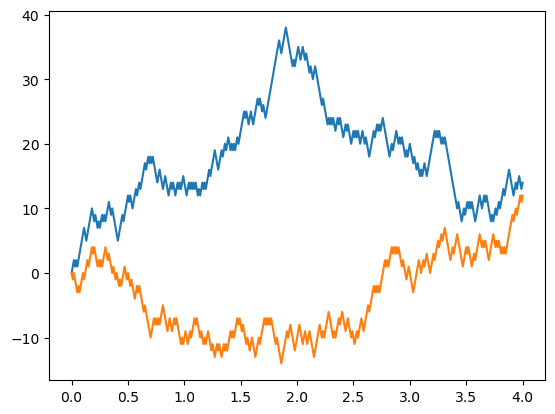

In [3]:
plt.plot(x/100,ys_rw[0],x/100,ys_rw[2])

In [4]:
k = int(1)
ls = np.arange(k+1,N,1,dtype=int)
increment_kls = [msu.path_increment_discrete(int(l),k,ys_rw) for l in ls]

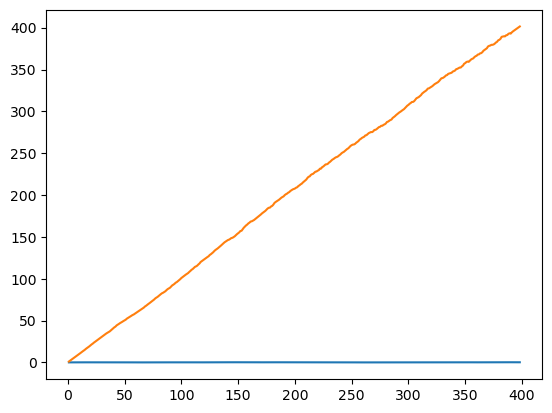

In [5]:
plt.plot(ls-k,increment_kls)

In [6]:
msu.quadratic_variation(2,ys_rw[0])

np.float64(2.0)

In [7]:
x_b,ys_b = msu.approximate_brownian_motion(100,4,M)

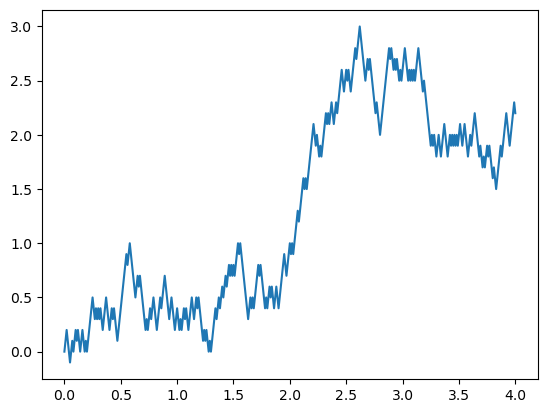

In [8]:
plt.plot(x_b,ys_b[0])

In [9]:
T = 10
steps = 10000
x_bc, ys_bc = msu.continuous_brownian_motion(T,steps,M)

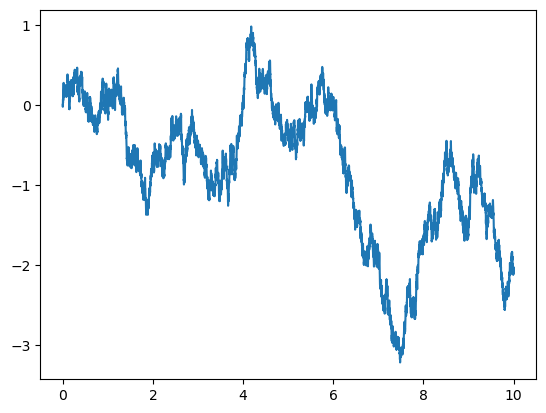

In [10]:
plt.plot(x_bc,ys_bc[1])

In [11]:
x_gbm, ys_gbm = msu.geometric_brownian_motion(100,0.08,0.2,10,400,1000)

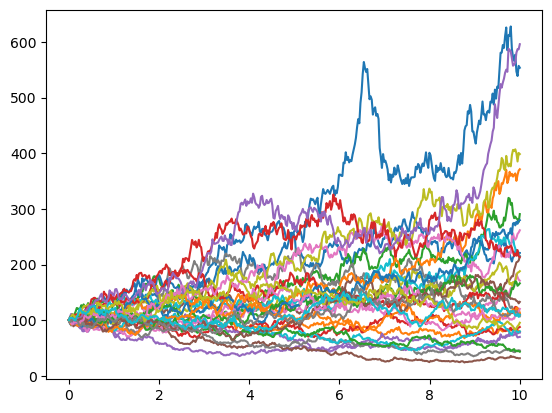

In [12]:
for ys in ys_gbm[10:40]:
    plt.plot(x_gbm,ys)

In [13]:
start,end = '2022-01-01','2025-01-01'
spy_data = msu.fetch_stock_data(start,end,["SPY"])

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:98: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


In [14]:
close_price = spy_data["CLOSE_SPY"].dropna()
close_log = spy_data["LOG_RETURN_SPY"].dropna()
years_past = (spy_data.index[-1] - spy_data.index[0]).days / 364.25

In [15]:
initial_price = close_price.iloc[0]
empirical_vol = np.sqrt(252) * close_log.std()
empirical_mean = (1/years_past)*np.log(close_price.iloc[-1]/close_price.iloc[0]) + 0.5*empirical_vol**2

In [16]:
print(empirical_mean, empirical_vol)

0.09812160282979893 0.17520637782885556


In [17]:
sim_count=1000
time_steps, predicted_spys = msu.gbm_price_sim(start,end,"SPY",sim_count)

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:98: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


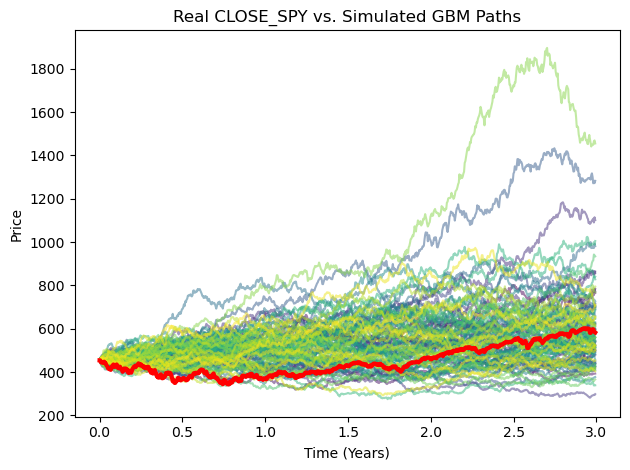

In [ ]:
mpu.plot_simulated_close_price(time_steps,predicted_spys,close_price,display_count=100,show_legend=False)

In [42]:
import pandas as pd

def gbm_price_sim(start:str,end:str,stock_ticker:str, realizations:int) -> tuple[pd.DataFrame,np.ndarray,np.ndarray]:

    price_log_data = msu.fetch_stock_data(start,end,[stock_ticker])
    close_log_return = price_log_data[f"LOG_RETURN_{stock_ticker}"]
    close_price = price_log_data[f"CLOSE_{stock_ticker}"]
    all_times = price_log_data.index
    T = (all_times[-1] - all_times[0]).days / 365.25

    initial_price = close_price.iloc[0]
    empirical_vol = np.sqrt(252) * close_log_return.std()
    empirical_mean = (1/T)*np.log(close_price.iloc[-1]/initial_price) + 0.5*empirical_vol**2

    time_steps, simulated_prices = msu.geometric_brownian_motion(initial_price,empirical_mean,empirical_vol,T,len(all_times),realizations)

    return price_log_data ,time_steps, simulated_prices

def gbm_price_sim_df(start:str,end:str,stock_ticker:str, realizations:int) -> tuple[np.ndarray,pd.DataFrame,pd.DataFrame]:
    price_log_data , time_steps, simulated_prices = gbm_price_sim(start,end,stock_ticker, realizations)

    return time_steps, pd.DataFrame(data=simulated_prices.T,index=price_log_data.index,columns=[(f"CLOSE_SIM_{i+1}").upper() for i in range(realizations)]) ,price_log_data

def log_returns_gbm_price_sim(simulation_df:pd.DataFrame):

    log_return_cols = []
    for _, col_data in simulation_df.items():
        log_returns = np.log(col_data.pct_change() + 1)
        log_return_cols.append(log_returns.to_frame())

    
    log_return_df = pd.concat(log_return_cols,axis=1)
    log_return_df.columns = [f"LOG_RETURN_SIM_{i+1}" for i in range(simulation_df.shape[1])]

    return log_return_df


In [43]:
time_steps, simulation_df, stock_df = gbm_price_sim_df(start,end,"SPY",sim_count)

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:98: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


In [44]:
log_returns_gbm_price_sim(simulation_df)

,LOG_RETURN_SIM_1,LOG_RETURN_SIM_2,LOG_RETURN_SIM_3,LOG_RETURN_SIM_4,LOG_RETURN_SIM_5,LOG_RETURN_SIM_6,LOG_RETURN_SIM_7,LOG_RETURN_SIM_8,LOG_RETURN_SIM_9,LOG_RETURN_SIM_10,...,LOG_RETURN_SIM_991,LOG_RETURN_SIM_992,LOG_RETURN_SIM_993,LOG_RETURN_SIM_994,LOG_RETURN_SIM_995,LOG_RETURN_SIM_996,LOG_RETURN_SIM_997,LOG_RETURN_SIM_998,LOG_RETURN_SIM_999,LOG_RETURN_SIM_1000
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-04,-0.010336,-0.005163,-0.006820,0.007563,0.009251,0.024692,0.003436,0.005953,0.035965,0.006535,...,0.004909,0.001841,0.001427,0.007495,0.001673,0.004687,-0.003642,0.012639,-0.005936,0.015222
2022-01-05,0.007764,0.013796,-0.008520,0.013779,-0.001826,0.003357,0.012500,-0.010440,0.005249,-0.002807,...,-0.024272,-0.012801,-0.006343,-0.000105,0.013633,-0.024206,-0.004035,-0.000975,0.015128,-0.000075
2022-01-06,0.009252,-0.004597,-0.010164,-0.000973,-0.006441,0.004662,-0.007066,0.000261,0.000534,-0.000903,...,-0.003020,0.008582,-0.004707,-0.008442,-0.015320,-0.008076,0.025742,0.007887,0.010807,0.011368
2022-01-07,-0.008850,0.006017,0.003993,0.012356,-0.012575,0.013719,-0.022296,-0.005087,-0.016321,0.006192,...,-0.014559,0.002311,-0.010007,0.000699,0.015866,0.005015,-0.004016,0.004864,-0.002637,0.012944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.009438,0.000377,0.001454,-0.013979,0.007628,0.003798,0.019809,0.003352,0.002122,-0.005399,...,-0.008058,-0.007007,0.014962,-0.002131,0.004900,0.007195,-0.008636,-0.008985,-0.009560,0.006935
2024-12-26,-0.011809,-0.002931,0.008596,0.012556,0.003948,0.000664,0.002336,0.007363,0.019570,0.008470,...,0.001248,-0.014239,0.014617,0.005653,-0.009850,0.002045,0.007351,-0.008044,-0.004045,0.012163
2024-12-27,-0.013004,0.011416,-0.015006,-0.024160,0.004884,-0.003986,0.009857,-0.008204,-0.016005,-0.000835,...,-0.008132,0.019026,0.016483,0.007596,-0.005931,0.008066,0.018410,0.011016,-0.010239,-0.001000


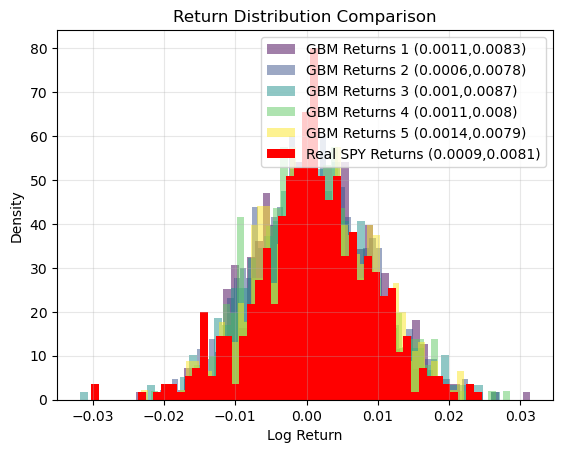

In [575]:
decimal_places = 4
for i in range(display_count):
    current_frame = simulated_df[(f"log_returns_run_{i+1}").upper()]
    mean, std = round(current_frame.mean(),decimal_places), round(current_frame.std(),decimal_places)
    plt.hist(simulated_df[(f"log_returns_run_{i+1}").upper()], bins=50, alpha=0.5, label=f'GBM Returns {i+1} ({mean},{std})',density=True,color=colors[i])
mean, std = round(close_log.mean(),decimal_places), round(close_log.std(),decimal_places)
plt.hist(close_log, bins=50, label=f'Real SPY Returns ({mean},{std})',density=True,color='red')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Return Distribution Comparison')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

In [576]:
simulated_moments = mbu.moments_df(simulated_df)
real_moments = mbu.moments_df(spy_data)

In [610]:
price_moments_mean = simulated_moments.loc["mean"].iloc[:sim_count]
price_moments_std = simulated_moments.loc["std"].iloc[:sim_count]
price_moments_skew = simulated_moments.loc["skew"].iloc[:sim_count]
price_moments_kurt = simulated_moments.loc["kurt"].iloc[:sim_count]

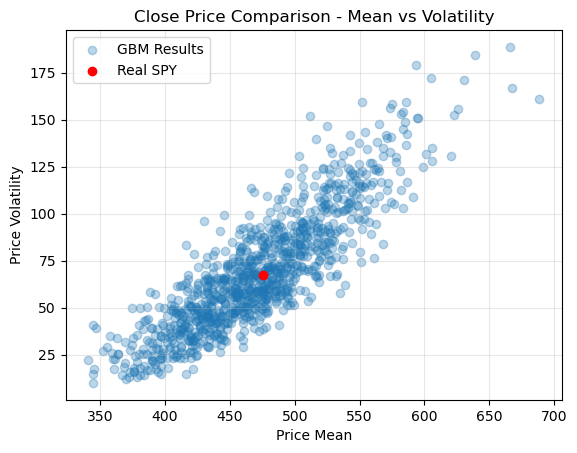

In [617]:
plt.scatter(price_moments_mean,price_moments_std,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["CLOSE_SPY"]["mean"]],[real_moments["CLOSE_SPY"]["std"]],color='red',label='Real SPY')
plt.xlabel('Price Mean')
plt.ylabel('Price Volatility')
plt.title('Close Price Comparison - Mean vs Volatility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

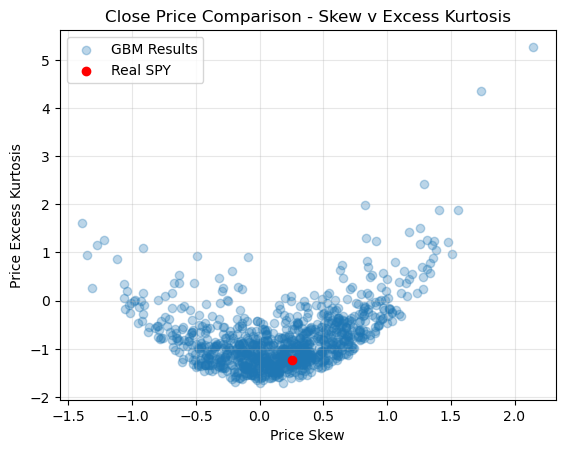

In [624]:
plt.scatter(price_moments_skew,price_moments_kurt,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["CLOSE_SPY"]["skew"]],[real_moments["CLOSE_SPY"]["kurt"]],color='red',label='Real SPY')
plt.xlabel('Price Skew')
plt.ylabel('Price Excess Kurtosis')
plt.title('Close Price Comparison - Skew v Excess Kurtosis')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

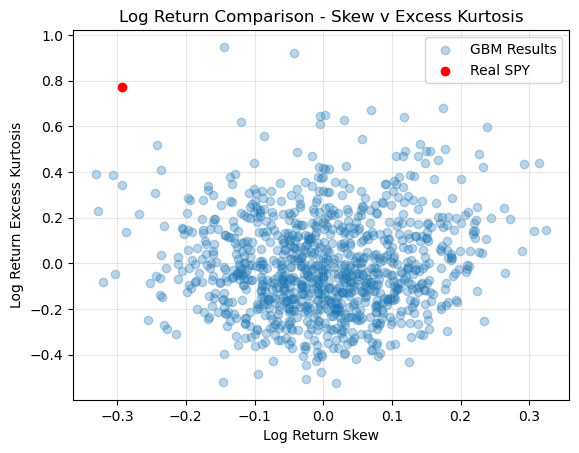

In [623]:
log_moments_mean = simulated_moments.loc["mean"].iloc[sim_count:]
log_moments_std = simulated_moments.loc["std"].iloc[sim_count:]
log_moments_skew = simulated_moments.loc["skew"].iloc[sim_count:]
log_moments_kurt = simulated_moments.loc["kurt"].iloc[sim_count:]

plt.scatter(log_moments_skew,log_moments_kurt,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["LOG_SPY"]["skew"]],[real_moments["LOG_SPY"]["kurt"]],color='red',label='Real SPY')
plt.xlabel('Log Return Skew')
plt.ylabel('Log Return Excess Kurtosis')
plt.title('Log Return Comparison - Skew v Excess Kurtosis')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

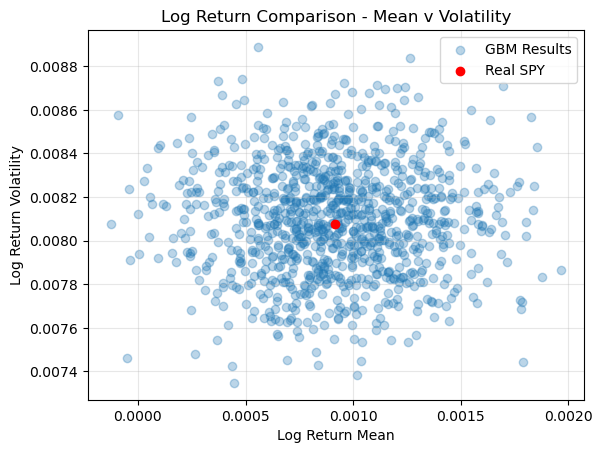

In [ ]:
plt.scatter(log_moments_mean,log_moments_std,alpha=0.3,label="GBM Results")
plt.scatter([real_moments["LOG_SPY"]["mean"]],[real_moments["LOG_SPY"]["std"]],color='red',label='Real SPY')
plt.xlabel('Log Return Mean')
plt.ylabel('Log Return Volatility')
plt.title('Log Return Comparison - Mean v Volatility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

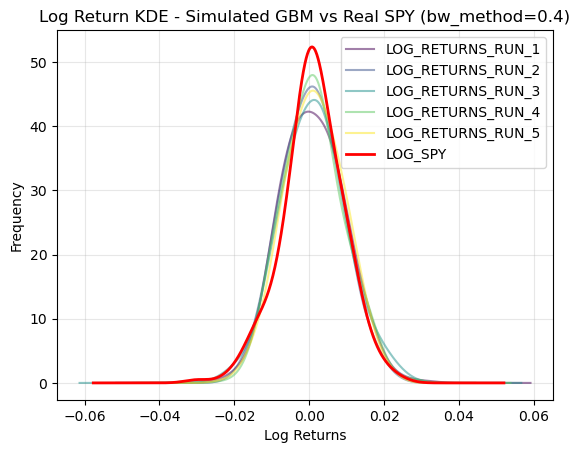

In [668]:
all_data = pd.concat([simulated_df,spy_data],axis=1)
method = 0.4
ax = all_data[[(f"log_returns_run_{i+1}").upper() for i in range(display_count)]].plot.kde(alpha=0.5,color=colors,bw_method=method)
all_data["LOG_SPY"].plot.kde(ax=ax,linewidth=2,alpha=1.0,color='red',label="LOG_SPY",bw_method=method)
plt.title(f"Log Return KDE - Simulated GBM vs Real SPY (bw_method={method})")
plt.ylabel('Frequency')
plt.xlabel('Log Returns')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [674]:
window = "30D"
all_log_data = all_data[[(f"log_returns_run_{i+1}").upper() for i in range(sim_count)]+["LOG_SPY"]]
all_log_rolling = all_log_data.rolling(window=window)

all_rollings = []
for i in range(sim_count+1):
    if i == sim_count:
        key = "LOG_SPY"
    else:
        key = (f"log_returns_run_{i+1}").upper() 
    
    single_rollings = all_log_rolling[key].std()
    all_rollings.append(single_rollings)

cols_to_dict = [s.to_dict() for s in all_rollings]
rolling_vol = pd.DataFrame(cols_to_dict).T
rolling_vol.rename(lambda x: (f"log_returns_run_{x+1}").upper() if x != sim_count else "LOG_SPY" ,axis="columns",inplace=True)

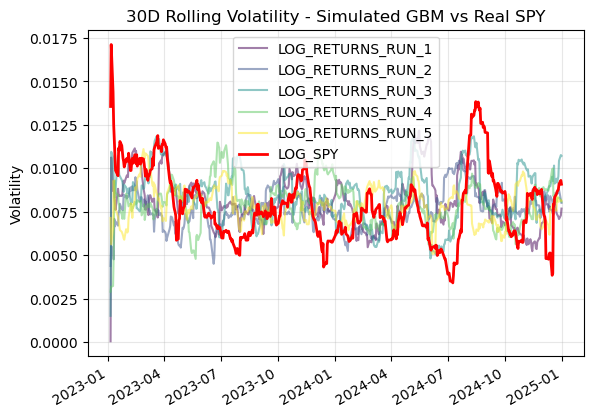

In [675]:
ax = rolling_vol[[(f"log_returns_run_{i+1}").upper() for i in range(display_count)]].plot(alpha=0.5,color=colors)
rolling_vol["LOG_SPY"].plot(ax=ax,linewidth=2,alpha=1.0,color='red',label='LOG_SPY')
plt.title(f'{window} Rolling Volatility - Simulated GBM vs Real SPY')
plt.ylabel('Volatility')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [2]:
time_steps, simulation_relts = msu.gbm_price_sim('2023-01-01','2025-01-01',"SPY",1000)

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:117: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


In [3]:
true_data = msu.fetch_stock_data('2023-01-01','2025-01-01',["SPY"])["CLOSE_SPY"]

c:\Users\Austen Couvertier\OneDrive\Desktop\Coding_Projects\phase_1_stochastic_pricing_risk_toolkit\market_simulation_utils.py:117: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(ticker_list,start=start,end=end,group_by='ticker',keepna=True,ignore_tz=True)
[*********************100%***********************]  1 of 1 completed


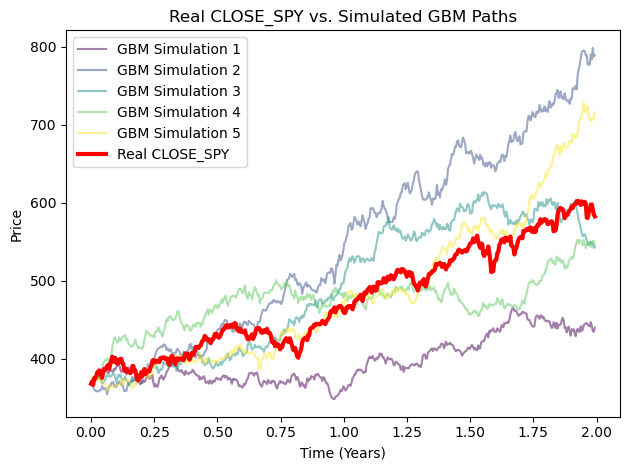

In [ ]:
mpu.plot_simulated_close_price(time_steps,simulation_relts,true_data) 